## DSS example

Find the linear combinations of multichannel data that maximize repeatability over trials. Data have shape (time, channels, trials).

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.join(os.getcwd(), '..'))

from meegkit import dss  # noqa:E402
from meegkit.utils import unfold, rms, fold, tscov  # noqa:E402

%matplotlib inline

Now create some synthetic data

In [2]:
n_samples = 100 * 3
n_chans = 30
n_trials = 100
noise_dim = 20  # dimensionality of noise

# source
source = np.hstack((
    np.zeros((n_samples // 3,)),
    np.sin(2 * np.pi * np.arange(n_samples // 3) / (n_samples / 3)).T,
    np.zeros((n_samples // 3,))))[np.newaxis].T
s = source * np.random.randn(1, n_chans)  # 300 * 30
s = s[:, :, np.newaxis]
s = np.tile(s, (1, 1, 100))

# noise
noise = np.dot(
    unfold(np.random.randn(n_samples, noise_dim, n_trials)),
    np.random.randn(noise_dim, n_chans))
noise = fold(noise, n_samples)

# mix signal and noise
SNR = 0.1
data = noise / rms(noise.flatten()) + SNR * s / rms(s.flatten())

We apply DSS to find the most repeatable component. Components are ordered by DSS, the first component being the one that maximises the criterion (in this case, repeatability over trials).

In [3]:
c0, _ = tscov(data)
c1, _ = tscov(np.mean(data, 2))
[todss, _, pwr0, pwr1] = dss.dss0(c0, c1)
z = fold(np.dot(unfold(data), todss), epoch_size=n_samples)

best_comp = np.mean(z[:, 0, :], -1)

Now plot some results

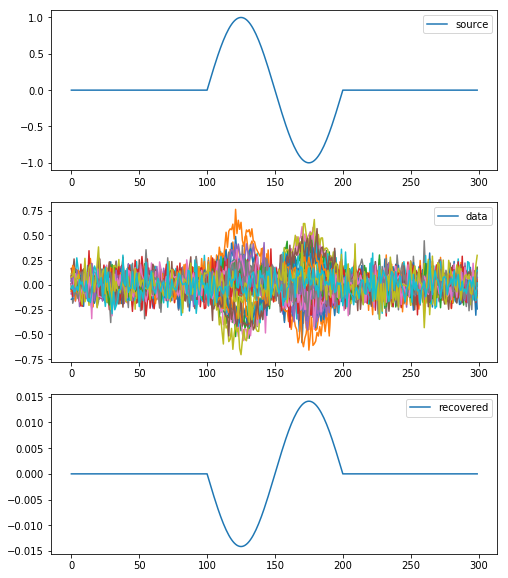

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
ax1.plot(source)
ax1.legend(['source', ])
ax2.plot(np.mean(data, 2))
ax2.legend(['data', ])
ax3.plot(best_comp)
ax3.legend(['recovered', ])
plt.show()